# **Complete subsampling pipeline breakdown**

## 1) Start with our imports:

### The cell below contains the imports needed for `src/pipeline/pipeline.py`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
import datetime as dt

from tqdm import tqdm

### The cell below contains the imports needed for `src/pipeline/audio_segmentor.py`

In [2]:
import os
import soundfile as sf

### The cell below contains the imports needed for `src/cli.py`

In [3]:
import sys

# # append the path of the
# # parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [4]:
from src.pipeline import pipeline
import src.subsampling as ss

## 2) Write any custom methods below:

### a) Below method is the implementation of subsampling we used for generating detections used in the Symposium results
#### &nbsp;&nbsp;&nbsp; i) Takes in segmented_file_paths from MSDS pipeline
#### &nbsp;&nbsp;&nbsp; ii) Filters out segmented_file_paths generated from MSDS pipeline. 
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Removes paths that would not exist if the recorder incorporated duty cycling by using the `percent_on` and `cycle_length` parameters of duty cycle.

In [5]:
def subsample_withpaths(segmented_file_paths, cfg, cycle_length, percent_on):
    necessary_paths = []

    for path in segmented_file_paths:
        if (path['offset'] % cycle_length == 0 # Check if starting position is within recording period; won't need to check rest of boolean if it is
            or ((path['offset']+cfg['segment_duration'])%cycle_length > 0 and (path['offset']+cfg['segment_duration'])%cycle_length <= int(cycle_length*percent_on))):
            necessary_paths.append(path)

    return necessary_paths

### b) Below method is a modified version of the MSDS run_models method
#### &nbsp;&nbsp;&nbsp; i) Runs only the batdetect2 submodule to generate only search-phase call detections.

In [6]:
## Run models and get detections!
def run_models(file_mappings, cfg, csv_name):
    bd_dets = pd.DataFrame()
    for i in tqdm(range(len(file_mappings))):
        cur_seg = file_mappings[i]
        bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
        bd_preds = pipeline._correct_annotation_offsets(
                bd_annotations_df,
                cur_seg['original_file_name'],
                cur_seg['audio_seg']['offset']
            )
        bd_dets = pd.concat([bd_dets, bd_preds])

    bd_dets.to_csv(f"{cfg['output_dir']}/{csv_name}", index=False)

    return bd_dets

## 3) Where does the subsampling pipeline start?

### Let's start with an audio file to demonstrate how we used our `subsampling.py` script

In [7]:
filepath = f"{Path.home()}/Documents/Research/Lab_related/example/original_recording"
filename = "20210910_030000.WAV"

### The below command is the command line invocation of the subsampling pipeline.

#### **Command: `python src/subsampling.py ../Documents/Research/Lab_related/example/original_recording '5min_every_30min__Central_20210910_030000.csv' 'output_dir' 'output/tmp' 1800 0.167`**

- `../Documents/Research/Lab_related/example/original_recording` is the folder path that contains our recording. 
   - Our pipeline takes in a folder and generates detections for every recording in those folders
- `5min_every_30min__Central_20210910_030000.csv` is the name of the output detections .csv.
   - For multiple consecutive recordings, we've labelled the output file as "...030000to130000.csv"
- `output_dir` is the repository folder where output detections .csv files will be saved.
- `output/tmp` is the repository folder where generated segment recordings will be saved and deleted after detections have been generated.
- `1800` is the provided cycle_length to generate duty cycled detections. 1800(s) is the number of seconds in 30min
- `0.167` is the provided percent_on to generate duty cycled detections. 0.167 is the duty cycle percentage. 

The subsampling scheme given is 300s (1800*0.167) or 5min every 30min. 

The location the recording was recorded from was Central Pond.

The recording was recorded on 09/10/2021 at 8pm PST.

**We wrote in these details into the output detections .csv file name.**

### Calling the above command runs the following code:

- `args = parse_args()`: **Takes in the command line positional arguments**

- `run_subsampling_pipeline(args['input_dir'], args['cycle_length'], args['percent_on'], args['csv_filename'], args['output_dir'], args['temp_dir'])`

## 4) A look into the `run_subsampling_pipeline()` method

In [8]:
def run_subsampling_pipeline(input_dir, cycle_length, percent_on, csv_name, output_dir, tmp_dir):
    cfg = ss.get_params(output_dir, tmp_dir, 4, 30.0)
    audio_files = sorted(list(Path(input_dir).iterdir()))
    segmented_file_paths = ss.generate_segmented_paths(audio_files, cfg)
    
    ## Get file paths specific to our subsampling parameters
    if (percent_on < 1.0):
        necessary_paths = subsample_withpaths(segmented_file_paths, cfg, cycle_length, percent_on)
    else:
        necessary_paths = segmented_file_paths

    file_path_mappings = ss.initialize_mappings(necessary_paths, cfg)
    bd_dets = run_models(file_path_mappings, cfg, csv_name)

    return bd_dets

### Description: 

This pipeline runs very similar to the MSDS pipeline with a few modifications:
1) A level of filtering to simulate duty cycling using the generated MSDS segments.
2) Only running batdetect2 for search-phase call detections in run_models

If one wishes to run the pipeline without any duty cycling, simply provide a `percent_on` of 1.0

In [9]:
ss.run_subsampling_pipeline(filepath, 360, 0.167, '1min_every_6min__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

100%|██████████| 10/10 [00:54<00:00,  5.44s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,726.5015,726.5129,24609.0,31793.0,0.570,Echolocation,20210910_030000.WAV
1,726.6575,726.6712,23750.0,30947.0,0.510,Echolocation,20210910_030000.WAV
2,727.0355,727.0591,21171.0,27033.0,0.528,Echolocation,20210910_030000.WAV
3,727.3045,727.3254,21171.0,28485.0,0.564,Echolocation,20210910_030000.WAV
4,727.8175,727.8405,21171.0,27830.0,0.550,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
80,1498.2985,1498.3119,23750.0,28609.0,0.673,Echolocation,20210910_030000.WAV
81,1498.7365,1498.7499,24609.0,28873.0,0.588,Echolocation,20210910_030000.WAV
82,1499.2145,1499.2291,23750.0,28587.0,0.648,Echolocation,20210910_030000.WAV
83,1499.5175,1499.5324,23750.0,28491.0,0.590,Echolocation,20210910_030000.WAV


In [10]:
ss.run_subsampling_pipeline(filepath, 1800, 0.167, '5min_every_30min__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

100%|██████████| 10/10 [00:54<00:00,  5.41s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,246.9325,246.9418,28046.0,37602.0,0.549,Echolocation,20210910_030000.WAV
1,247.2165,247.2264,28046.0,38133.0,0.573,Echolocation,20210910_030000.WAV
2,247.3525,247.3627,28046.0,38892.0,0.555,Echolocation,20210910_030000.WAV
3,247.4715,247.4794,27187.0,42404.0,0.763,Echolocation,20210910_030000.WAV
4,247.5905,247.6001,28046.0,37383.0,0.530,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
57,257.2315,257.2460,22031.0,28742.0,0.614,Echolocation,20210910_030000.WAV
58,257.3965,257.4096,23750.0,29575.0,0.628,Echolocation,20210910_030000.WAV
59,258.3155,258.3265,24609.0,31268.0,0.639,Echolocation,20210910_030000.WAV
60,258.8635,258.8733,24609.0,30445.0,0.553,Echolocation,20210910_030000.WAV


In [11]:
ss.run_subsampling_pipeline(filepath, 1800, 1.0, 'continuous__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

100%|██████████| 60/60 [05:25<00:00,  5.43s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,246.9325,246.9418,28046.0,37602.0,0.549,Echolocation,20210910_030000.WAV
1,247.2165,247.2264,28046.0,38133.0,0.573,Echolocation,20210910_030000.WAV
2,247.3525,247.3627,28046.0,38892.0,0.555,Echolocation,20210910_030000.WAV
3,247.4715,247.4794,27187.0,42404.0,0.763,Echolocation,20210910_030000.WAV
4,247.5905,247.6001,28046.0,37383.0,0.530,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
49,1781.4465,1781.4565,25468.0,32664.0,0.584,Echolocation,20210910_030000.WAV
50,1781.5785,1781.5891,26328.0,32298.0,0.577,Echolocation,20210910_030000.WAV
51,1781.9385,1781.9477,26328.0,34069.0,0.614,Echolocation,20210910_030000.WAV
52,1782.0615,1782.0702,25468.0,34393.0,0.600,Echolocation,20210910_030000.WAV


## 5) Output detections and generating comparisons

### a) Comparing effects with spectrograms

#### Below is main method to compare the effects of different duty cycling schemes by-sight

In [9]:
def plt_msds_fromdf(location, filename, df, audio_sec, fs, offset, reftimes, times, cycle_length, p_on, be_subplot=False, show_PST=False, show_legend=False, show_threshold=False, lf_threshold=40000, hf_threshold=40000, show_num_dets=False, det_linewidth=2, show_audio=False, show_spectrogram=True, spec_cmap='ocean', spec_NFFT = 256, rm_dB = 200, save=False, save_dir='../output_dir'):
    
    ## If user wants to plot in PST time, adjust the hour accordingly to read into datetime
    hour = int(filename[9:11])
    if (show_PST):
        if (hour >= 7):
            hour = hour - 7
        else:
            hour = 24 + hour - 7
    zero_pad_hour = str(hour).zfill(2)

    ## Strip the datetime for year, month, date, and hour from filename
    file_dt = dt.datetime.strptime(f'{filename[:9]}{zero_pad_hour}{int(offset/60)%60}{int(offset%60)}', '%Y%m%d_%H%M%S')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    if times[1] < 400:
        if times[1] < 150: # If duration of plotted signal is less than 150s, show detail up to microseconds for each time stamp.
            time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                                day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                                minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60), 
                                                microsecond=np.round(1e6*((file_dt.second + sec)%60-int((file_dt.second + sec)%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                                for sec in sec_labels]
        else: # If duration of plotted signal is less than 400s but greater than 150s, show detail up to seconds for each time stamp.
            time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                            day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                            minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60)).strftime('%T')
                                            for sec in sec_labels]
    else: # If duration of plotted signal is greater than 400s, show detail up to minutes only for each time stamp.
        time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                            day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                            minute=(file_dt.minute + int((file_dt.second + sec)/60))%60).strftime('%H:%M') 
                                            for sec in sec_labels]
    
    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = ss.get_msds_params_from_df(df, reftimes[0]+times)
    vmin = 20*np.log10(np.max(audio_sec)) - rm_dB  # hide anything below -rm_dB dB

    ## Create figure for the audio signal: multiple figures can be generated with this method
    legend_fontsize = 16 # This is the fontsize for the text in the legend
    ylabel_fontsize = 20 # This is the fontsize for the text in the ylabel

    if (show_audio): # If show_audio is true, the plot will consist of an audio signal along with a spectrogram of the given audio signal
        ## Throughout this method, some if cases are written to handle more intensive plots by only plotting what's necessary
        ## So for audio signals of greater than 20mins, there will be less intensive plots like generating spectrograms

        if (times[1] < 1200): # If the signal is less than 20mins, we plot 3 subplots: audio signal, spectrogram, and a spectrogram w/ detections
            plt.figure(figsize=(18, 12))
            plt.subplot(311)
        else: # If the signal is greater than 20mins, we plot only 2 subplots: audio signal and a spectrogram w/ detections
            plt.figure(figsize=(12, 8))
            plt.subplot(211)

        ## Plot the provided audio as a signal in this section
        plt.title(f"Audio from {file_dt.date()} in {location}, {time_labels[0]} to {time_labels[-1]}")
        plt.plot(audio_sec)
        plt.xlim((0, s_ticks[-1]*fs))
        plt.xticks(ticks=x_ticks, labels=time_labels)
        amp_ticks = plt.yticks()[0]
        plt.ylabel("Amplitude (V)", fontsize=ylabel_fontsize)
        if (np.max(amp_ticks) > 1000):
            plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
            plt.ylabel("Amplitude (kV)")
        plt.ylim((amp_ticks[0], amp_ticks[-1]))
        plt.grid(which="both")
        
        ## Moving on to the next subplot
        if (times[1] < 1200): # Plot the spectrogram of the audio signal in the case of signal being less than 20mins
            plt.subplot(312)
            plt.title(f"Spectrogram Representation showing Frequencies {0} to {fs//2000}kHz")
            plt.specgram(audio_sec, Fs=fs, cmap=spec_cmap, vmin=vmin)
            plt.ylabel("Frequency (kHz)", fontsize=ylabel_fontsize)
            plt.xticks(ticks=s_ticks, labels=time_labels)
            plt.xlim((0, s_ticks[-1]))
            ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
            f_ticks = plt.yticks()[0]
            f_ticks = f_ticks[f_ticks <= fs/2]
            plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

            ## Plotting Spectrogram with MSDS outputs overlayed
            plt.subplot(313)
        else: # Create a subplot for the spectrogram w/ detections in the case of signal being greater than 20mins
            plt.subplot(212)
        ## Give a title to the subplot with the spectograms w/ detections overlayed
        plt.title(f"Spectrogram Representation with Call Detections Overlayed")

    else: # If show_audio is false, the plot will consist of only a spectrogram of the given audio signal
        ## be_subplot provides functionality to either plot spectrogram as its own plot or include it with other method call plots
        if (not(be_subplot)):
            plt.figure(figsize=(12, 4))
            plt.title(f"{file_dt.date()} in {location} | {cycle_length//60}-min, {100*p_on:.1f}% Duty Cycle")

    ## show_spectrogram provides functionality to hide the spectrogram if one wanted to just show the subsampling scheme
    if (show_spectrogram): 
        ## User is allowed to set their own NFFT, cmap, and vmin to plot clear customizable spectrograms
        plt.specgram(audio_sec, NFFT=spec_NFFT, Fs=fs, cmap=spec_cmap, vmin=vmin)

    ## Set the generalizable plt features such as xlim, ylabel, and xticks
    plt.xlim((0, s_ticks[-1]))
    plt.ylabel("Frequency (kHz)", fontsize=ylabel_fontsize)
    plt.xticks(ticks=s_ticks, labels=time_labels)

    ## If show_PST is on, set xlabel as PST, 
    if (show_PST):
        if (times[1] < 400): # If timestamps are in second-precision, set xlabel units as (HH:MM:SS)
            plt.xlabel("PST Time (HH:MM:SS)")
        else: # If timestamps are in minute-precision, set xlabel units as (HH:MM)
            plt.xlabel("PST Time (HH:MM)")
    else:
        if (times[1] < 400): # If timestamps are in second-precision, set xlabel units as (HH:MM:SS)
            plt.xlabel("UTC Time (HH:MM:SS)")
        else:
            plt.xlabel("UTC Time (HH:MM)") # If timestamps are in minute-precision, set xlabel units as (HH:MM)

    # Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

    ## Below section pertains to plotting detections and managing legend information on the spectrogram
    ax = plt.gca()
    num_dets = 0 # Keep track of number of detections plotted to display after in legend
    
    ## Iterate through detections and draw yellow boxes around each detection within the recording period
    for i in range(len(xs_inds)):
        rect = patches.Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=det_linewidth, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ## Only plot the detection boxes if they are within the simulated recording period
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio_sec) and audio_sec[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
            num_dets += 1

    ## Next we will display semi-opaque regions for simulated recording and sleep periods
    if (show_spectrogram):
        ## When showing the spectrogram, these regions will be semi-transparent yellow that blend w/ spectrogram to appear green
        on_color = "yellow"
        on_alpha = 0.2
    else:
        ## When showing only the subsampling schemes (no audio and spectrogram), these regions will be black to contrast with white
        on_color = 'black'
        on_alpha = 1.0

    ## Below we handle threshold lines, legends, and simulated regions
    if (not(show_audio)): # This case exists when we want to compare verious spectrograms together w/out showing audio
        ## Here we show threshold so audience can see where clusters of bat calls lie across frequency against a threshold
        if (p_on == 1.0): ## This threshold goes from 0 to the end of audio plot as it is for a continuouus recording
            if (show_threshold):
                    plt.axhline(hf_threshold, xmin=0, xmax=(audio_sec.shape[0])/times[1], linestyle='dashed', color='cyan')
        for tick in sec_labels:
            ## This is a region for duty cycled recording
            if (p_on < 1.0 and int(tick)%cycle_length == 0):
                ## In the case where we want to show threshold in duty cycled recording, the threshold will need to follow recording periods
                if (show_threshold):
                    plt.axhline(hf_threshold, xmin=(int(tick)-reftimes[0])/times[1], xmax=(int(tick)-reftimes[0] + int(p_on*cycle_length))/times[1], linestyle='dashed', color='cyan')
                rect = patches.Rectangle((int(tick)-reftimes[0], 0), width=int(p_on*cycle_length), height=fs/2, linewidth=1, edgecolor=on_color, facecolor=on_color, alpha=on_alpha)
                ax.add_patch(rect)
            
            ## This is a region for continuous recording
            if (p_on == 1.0):
                tick = int(tick) - reftimes[0]
                if (tick%(reftimes[1] - reftimes[0]) == 0):
                    rect = patches.Rectangle((tick, 0), width=int(audio_sec.shape[0] / fs), height=fs/2, linewidth=1, edgecolor=on_color, facecolor=on_color, alpha=on_alpha)
                    ax.add_patch(rect)

        ## Here we handle plotting of the legend for the multiple regions we wish to show
        if (show_spectrogram): ## This also is only a feature when show_spectrogram is true
            ## Yellow is the color we use for the detections and detection boxes
            yellow_rect = patches.Patch(edgecolor=on_color, facecolor=on_color, label = f"{num_dets} Detections")
            ## Green which is really semi-transparent yellow overlayed onto a blue spectrogram is used for simulated recording period
            green_rect = patches.Patch(edgecolor='yellow', facecolor="green", alpha = 0.5, label="Simulated Recording Period")
            ## Blue is the color used for simulated sleep period as majority of the spectrogram background w/out yellow region overlay is blue
            blue_rect = patches.Patch(edgecolor='k', facecolor="royalblue", alpha=0.8, label="Simulated Sleep Period")

            ## Showing legend implies we are including details of recording period, sleep period, and # of dets
            if (show_legend):
                ## Given specific white spaces and region positions, these are several if-cases to position the legend in a pleasing way
                if (p_on < 1.0):
                    if (sec_labels[0]==0):
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, loc=1)
                    else:
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, loc=2)
                else:
                    if (sec_labels[0]==0):
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, ncol=3, loc=1)
                    else:
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, ncol=3, loc=2)

            ## We wish to sometimes show number of detections even when show_legend is false. This is for that case
            if (show_num_dets):
                plt.legend(handles=[yellow_rect], fontsize=legend_fontsize, loc=1)

    else: # When we are showing audio and showing spectogram, we again only plot the # of yellow detection boxes
        if (show_spectrogram):
            if (show_legend):
                yellow_rect = patches.Patch(edgecolor=on_color, facecolor=on_color, label = f"{num_dets} Detections")
                if (sec_labels[0]==0):
                    plt.legend(handles=[yellow_rect], fontsize=legend_fontsize, loc=1)
                else:
                    plt.legend(handles=[yellow_rect], fontsize=legend_fontsize, loc=2)

    ## Let's autoformat the xticks/timestamps.
    ## In the case where we want to show only subsampling schemes (no spectorgram), we don't need proper timestamps
    if (show_spectrogram): 
        plt.gcf().autofmt_xdate()
    plt.tight_layout() # plt.tight_layout() is something I always done for final touch-ups

    ## Pretty basic save commands for plot using provided save directories
    if (save):
        directory = f'{save_dir}/{dt.datetime.strftime(file_dt, "%Y%m%d")}'
        start_datetime = dt.datetime.strftime(dt.datetime.strptime(time_labels[0], "%H:%M:%S.%f"), "%H%M%S")
        end_datetime = dt.datetime.strftime(dt.datetime.strptime(time_labels[-1], "%H:%M:%S.%f"), "%H%M%S")
        if not os.path.isdir(directory):
            os.makedirs(directory)

        ## If plot is a spectrogram only, then save under a specific folder for subsampling routine
        if (not(show_audio)):
            directory = f'{directory}/{int(cycle_length*p_on)//60}min_every_{cycle_length//60}min'
            if not os.path.isdir(directory):
                os.makedirs(directory)
            plt.savefig(
                f'{directory}/{location.split()[0]}{location.split()[1]}__{start_datetime}to{end_datetime}.png')
        else: # If plot is a spectrogram and audio, then save under a specific folder as examples/
            directory = f'{directory}/examples'
            if not os.path.isdir(directory):
                os.makedirs(directory)
            plt.savefig(
                f'{directory}/{location.split()[0]}{location.split()[1]}__{start_datetime}to{end_datetime}.png')
    
    ## If plot is its own figure (be_subplot=false), call plt.show()
    if (not(be_subplot)):
        plt.show()

In [10]:
summer_audio_files = sorted(list(Path(filepath).iterdir()))
date = "20210910"
location = "Central Pond"
plot_file_path = summer_audio_files[0]
plot_file = plot_file_path.name
plot_file_path

PosixPath('/Users/adityakrishna/Documents/Research/Lab_related/example/original_recording/20210910_030000.WAV')

In [11]:
offset = 0
audio_file = sf.SoundFile(plot_file_path)
fs = audio_file.samplerate
reftimes = np.array([0, 300])
times = np.array([0, reftimes[1] - reftimes[0]])
audio_file.seek(int(reftimes[0]*fs))
audio_sec = audio_file.read(int((reftimes[1] - reftimes[0])*fs))
plt.rcParams.update({'font.size': 18})

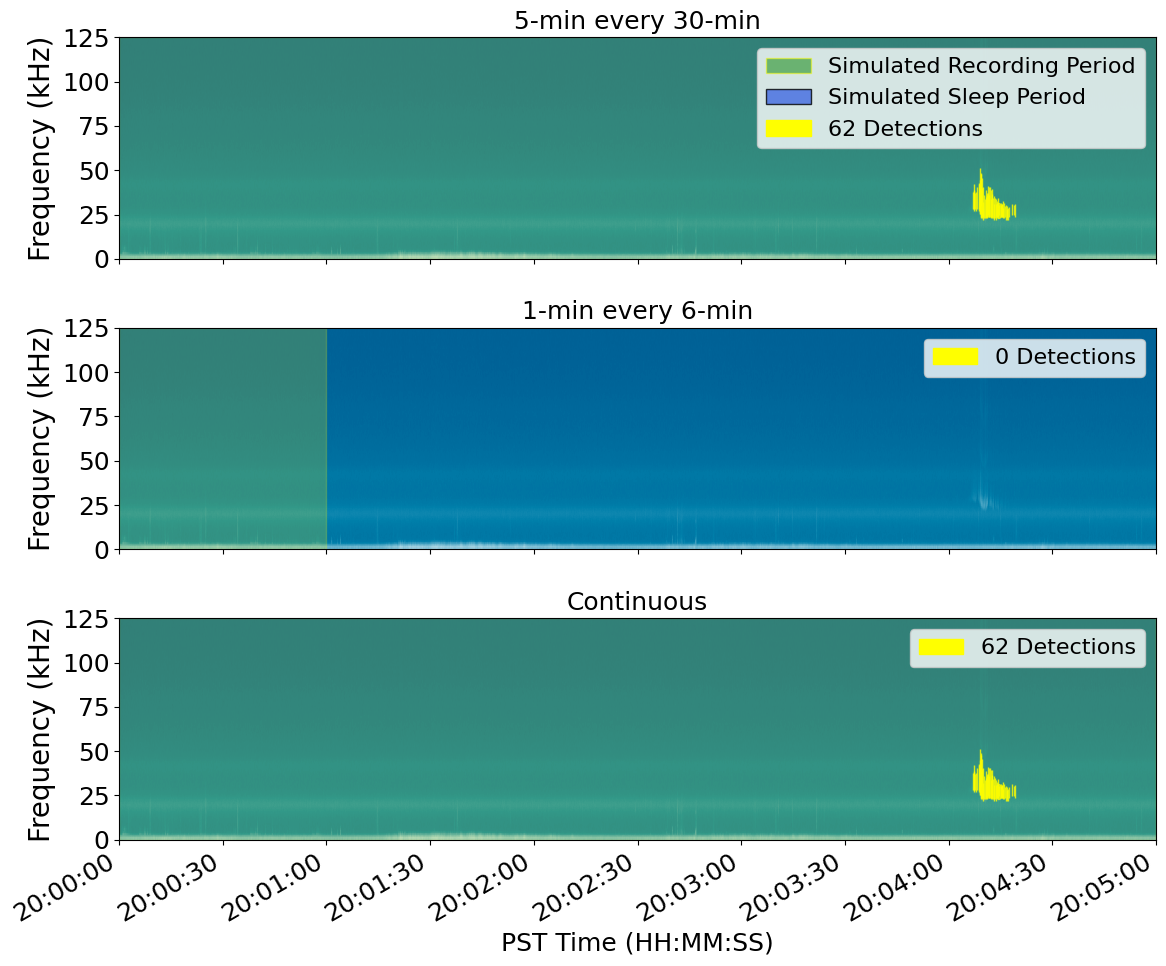

In [12]:
## Plot detections on audio
# Read in only section of audio with reftimes
# Zoom into section of audio with times

plt.figure(figsize=(12, 10))

cycle_length = 1800
percent_on = 0.167
dets = pd.read_csv(f"../output_dir/{int(cycle_length*percent_on)//60}min_every_{cycle_length//60}min__{location.split()[0]}_{date}_030000.csv")
plot_dets = dets[dets['input_file']==plot_file]
plt.subplot(311)
plt.title("5-min every 30-min", fontsize=18)
plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=True, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=False, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

cycle_length = 360
percent_on = 0.167
dets2 = pd.read_csv(f"../output_dir/{int(cycle_length*percent_on)//60}min_every_{cycle_length//60}min__{location.split()[0]}_{date}_030000.csv")
plot_dets = dets2[dets2['input_file']==plot_file]
plt.subplot(312)
plt.title("1-min every 6-min", fontsize=18)
plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=False, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=True, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

cycle_length = 1800
percent_on = 1.0
c_dets = pd.read_csv(f"../output_dir/continuous__{location.split()[0]}_{date}_030000.csv")
plot_dets = c_dets[c_dets['input_file']==plot_file]
plt.subplot(313)
plt.title("Continuous", fontsize=18)
plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=False, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=True, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

plt.tight_layout()
plt.show()

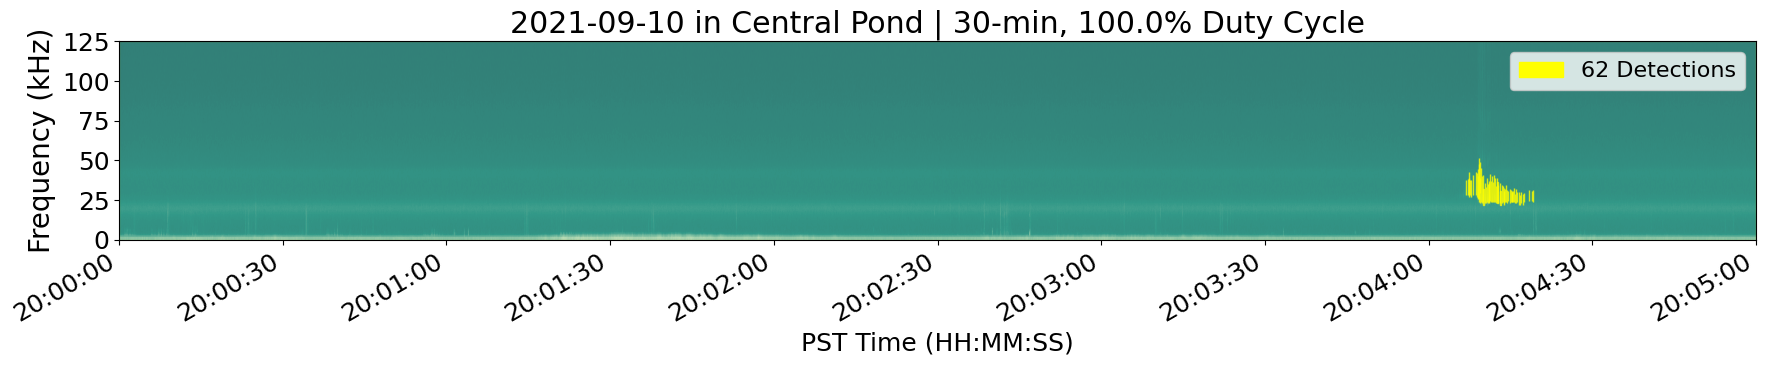

In [13]:
cycle_length = 1800
percent_on = 1.0
c_dets = pd.read_csv(f"../output_dir/continuous__{location.split()[0]}_{date}_030000.csv")
plot_dets = c_dets[c_dets['input_file']==plot_file]
plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=False, show_PST=True, show_legend=False, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=True, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)